Импорт и настройки

In [198]:
# %% [markdown]
# # US модель: расчёт WAPE + графики
# 
# Входные файлы:
# - input_US.xlsb / .xlsx — прогноз (лист "pivot")
# - catalog_US.xlsb / .xlsx — справочник (лист "Sheet1")
# - fact_US.xlsb / .xlsx — фактические данные (лист "fact")
# 
# Важно: в input_US в item_id формат "ДРАЙВЕР+ГОСБ" (пример: "12+A901")

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)

# Пути к файлам (подкорректируй при необходимости)
US_FORECAST_PATH = "input_US.xlsb"      # или .xlsx
US_CATALOG_PATH  = "catalog_US.xlsb"    # или .xlsx
US_FACT_PATH     = "fact_US.xlsb"       # или .xlsx

# Имена листов
US_FORECAST_SHEET = "pivot"
US_CATALOG_SHEET  = "Sheet1"
US_FACT_SHEET     = "FACT"

# Период для WAPE (год зададим, а месяцы можем подобрать автоматически)
WAPE_YEAR_US   = 2025          # можно поменять
WAPE_MONTHS_US = list(range(1, 6))  # 1..9 (если нужно считать 9 месяцев)


Очистка

In [199]:
# %% [markdown]
# ## Вспомогательные функции

# %%
def try_read_excel(path, sheet_name=None):
    """
    Пытаемся прочитать .xlsb с engine='pyxlsb', если модуль не установлен или файл не xlsb,
    падаем обратно на стандартный read_excel.
    """
    try:
        if str(path).lower().endswith(".xlsb"):
            return pd.read_excel(path, sheet_name=sheet_name, engine="pyxlsb")
        else:
            return pd.read_excel(path, sheet_name=sheet_name)
    except ModuleNotFoundError:
        print("⚠️ pyxlsb не установлен, пробуем прочитать без engine=")
        return pd.read_excel(path, sheet_name=sheet_name)


def normalize_code(series: pd.Series) -> pd.Series:
    """
    Нормализация кодов (driver/gosb): str, trim, upper, без пробелов.
    """
    return (
        series.astype(str)
        .str.strip()
        .str.upper()
        .str.replace(" ", "", regex=False)
    )


In [200]:
# %% [markdown]
# ## 1. Прогноз US: чтение и подготовка (input_US)

# %%
df_us_raw = try_read_excel(
    US_FORECAST_PATH,
    sheet_name=US_FORECAST_SHEET
)

print("Колонки в input_US:", df_us_raw.columns.tolist())
display(df_us_raw.head())

# %%
# Приводим имена колонок к нижнему регистру
df_us = df_us_raw.copy()
df_us.columns = [str(c).strip().lower() for c in df_us.columns]

# Определим основные столбцы
rename_map = {}
for col in df_us.columns:
    if "item" in col and "id" in col:
        rename_map[col] = "item_id"
    elif "time" in col:
        rename_map[col] = "timestamp"
    elif "mean" == col:
        rename_map[col] = "mean"

df_us = df_us.rename(columns=rename_map)

required_cols = ["item_id", "timestamp", "mean"]
missing = [c for c in required_cols if c not in df_us.columns]
if missing:
    raise ValueError(f"В input_US не найдены столбцы {missing}. Текущие: {df_us.columns.tolist()}")

df_us = df_us[required_cols].copy()
display(df_us.head())


Колонки в input_US: ['item_id', 'timestamp', 'mean', '0.1', '0.9']


,item_id,timestamp,mean,0.1,0.9
0,A901+12,45658,678.50,678.50,678.50
1,A902+12,45690,6345.30,6345.30,6345.30
2,A903+12,45719,7834.20,7834.20,7834.20
3,A901+15,45751,122.30,122.30,122.30
4,A902+15,45782,389.44,389.44,389.44


,item_id,timestamp,mean
0,A901+12,45658,678.50
1,A902+12,45690,6345.30
2,A903+12,45719,7834.20
3,A901+15,45751,122.30
4,A902+15,45782,389.44


In [201]:
# %% [markdown]
# ## 2. Разбор item_id (формат "ДРАЙВЕР+ГОСБ") и добавление дат

# %%
# item_id: например "12+A901" (первое — driver, второе — gosb)
df_us["item_id"] = df_us["item_id"].astype(str)
parts = df_us["item_id"].str.split("+", n=1, expand=True)

if parts.shape[1] != 2:
    print("⚠️ item_id не делится на две части по '+'. Примеры:")
    for v in df_us["item_id"].head(20):
        print(repr(v))
    raise ValueError("Проверь реальный формат item_id в input_US (ожидается 'ДРАЙВЕР+ГОСБ').")

df_us["driver_code"] = parts[0].str.strip()
df_us["gosb_code"]   = parts[1].str.strip()

# timestamp — Excel-сериал (типа 45658)
df_us["timestamp"] = pd.to_numeric(df_us["timestamp"], errors="coerce")
df_us["timestamp"] = pd.to_datetime(df_us["timestamp"], unit="D", origin="1899-12-30")

df_us["year"]        = df_us["timestamp"].dt.year
df_us["month"]       = df_us["timestamp"].dt.month
df_us["quarter_num"] = df_us["timestamp"].dt.quarter
df_us["quarter"]     = df_us["quarter_num"].astype(str) + "Q"

# Нормализуем коды под дальнейший merge
df_us["driver_code"] = normalize_code(df_us["driver_code"])
df_us["gosb_code"]   = normalize_code(df_us["gosb_code"])

print("Прогноз US после разборки item_id и дат:")
display(df_us.head())


Прогноз US после разборки item_id и дат:


,item_id,timestamp,mean,driver_code,gosb_code,year,month,quarter_num,quarter
0,A901+12,2025-01-01,678.50,A901,12,2025,1,1,1Q
1,A902+12,2025-02-02,6345.30,A902,12,2025,2,1,1Q
2,A903+12,2025-03-03,7834.20,A903,12,2025,3,1,1Q
3,A901+15,2025-04-04,122.30,A901,15,2025,4,2,2Q
4,A902+15,2025-05-05,389.44,A902,15,2025,5,2,2Q


Подготовка справочника

In [202]:
# %% [markdown]
# ## 3. Справочник US (catalog_US): driver_code → category

# %%
df_us_catalog_raw = try_read_excel(
    US_CATALOG_PATH,
    sheet_name=US_CATALOG_SHEET
)

print("Колонки в catalog_US:", df_us_catalog_raw.columns.tolist())
display(df_us_catalog_raw.head())

# %%
df_us_catalog = df_us_catalog_raw.copy()

# По описанию: C — категория, D — драйвер
cols = list(df_us_catalog.columns)
if len(cols) < 4:
    raise ValueError("catalog_US выглядит слишком узким. Ожидается хотя бы 4 колонки (A..D).")

col_category = cols[2]  # C
col_driver   = cols[3]  # D

df_us_catalog = df_us_catalog.rename(columns={
    col_category: "category",
    col_driver:   "driver_code"
})

df_us_catalog = df_us_catalog[["driver_code", "category"]].copy()
df_us_catalog["driver_code"] = normalize_code(df_us_catalog["driver_code"])
df_us_catalog["category"]    = df_us_catalog["category"].astype(str).str.strip()

df_us_catalog = df_us_catalog.drop_duplicates()

print("Справочник US (после подготовки):")
display(df_us_catalog.head())
print("Уникальных driver_code в catalog:", df_us_catalog["driver_code"].nunique())

# %%
# Обогащаем прогноз категорией
df_us_enriched = df_us.merge(
    df_us_catalog,
    how="left",
    on="driver_code"
)

print("Всего строк в df_us_enriched:", len(df_us_enriched))
print("Строк с пустой категорией:", df_us_enriched["category"].isna().sum())
display(df_us_enriched.head())


Колонки в catalog_US: ['Unnamed: 0', 'Unnamed: 1', 'Категория', 'Драйвер', 'Подразделение код', 'Unnamed: 5', 'Подразделение текст', 'Полугодие', 'Квартал', 'Месяц']


,Unnamed: 0,Unnamed: 1,Категория,Драйвер,Подразделение код,Unnamed: 5,Подразделение текст,Полугодие,Квартал,Месяц
0,NaN,NaN,Кат1,A901,12.0,NaN,М1,IHY,1Q,1
1,NaN,NaN,Кат2,A902,15.0,NaN,М2,IHY,1Q,2
2,NaN,NaN,Кат3,A903,10.0,NaN,М3,IHY,1Q,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IHY,2Q,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IHY,2Q,5


Справочник US (после подготовки):


,driver_code,category
0,A901,Кат1
1,A902,Кат2
2,A903,Кат3
3,NAN,nan


Уникальных driver_code в catalog: 4
Всего строк в df_us_enriched: 6
Строк с пустой категорией: 0


,item_id,timestamp,mean,driver_code,gosb_code,year,month,quarter_num,quarter,category
0,A901+12,2025-01-01,678.50,A901,12,2025,1,1,1Q,Кат1
1,A902+12,2025-02-02,6345.30,A902,12,2025,2,1,1Q,Кат2
2,A903+12,2025-03-03,7834.20,A903,12,2025,3,1,1Q,Кат3
3,A901+15,2025-04-04,122.30,A901,15,2025,4,2,2Q,Кат1
4,A902+15,2025-05-05,389.44,A902,15,2025,5,2,2Q,Кат2


In [203]:
# %% [markdown]
# ## 4. Факт US (fact_US): чтение и подготовка

# %%
df_fact_us_raw = try_read_excel(
    US_FACT_PATH,
    sheet_name=US_FACT_SHEET
)

print("Колонки fact_US:", df_fact_us_raw.columns.tolist())
display(df_fact_us_raw.head())

# %%
# По твоему описанию:
# A = Год           -> year
# B = Полугодие    (не нужно)
# C = Квартал      (не нужно)
# D = Месяц        -> month
# E = Тип данных   -> (можно использовать при фильтрации)
# F = Категория    -> category
# G = Драйвер      -> driver_code
# H = Подразделение (ГОСБ) -> gosb_code
# I = Значение     -> fact
# J, K             (не нужны)

df_fact_us = df_fact_us_raw.copy()
cols = list(df_fact_us.columns)

if len(cols) < 9:
    raise ValueError("fact_US выглядит слишком узким. Ожидается хотя бы 9 колонок (A..I).")

df_fact_us = df_fact_us.rename(columns={
    cols[0]: "year",        # A
    cols[3]: "month",       # D
    cols[4]: "data_type",   # E (если нужно будет фильтровать по типу)
    cols[5]: "category",    # F
    cols[6]: "driver_code", # G
    cols[7]: "gosb_code",   # H
    cols[8]: "fact",        # I
})

df_fact_us = df_fact_us[["year", "month", "data_type", "category", "driver_code", "gosb_code", "fact"]].copy()

# Нормализация типов
df_fact_us["driver_code"] = normalize_code(df_fact_us["driver_code"])
df_fact_us["gosb_code"]   = normalize_code(df_fact_us["gosb_code"])
df_fact_us["year"]        = pd.to_numeric(df_fact_us["year"], errors="coerce").astype("Int64")
df_fact_us["month"]       = pd.to_numeric(df_fact_us["month"], errors="coerce").astype("Int64")
df_fact_us["fact"]        = pd.to_numeric(df_fact_us["fact"], errors="coerce")

# (опционально) отфильтровать только строки с типом "Факт"
# df_fact_us = df_fact_us[df_fact_us["data_type"] == "Факт"]

print("Факт US после подготовки:")
display(df_fact_us.head())

print("Годы в fact:", sorted(df_fact_us["year"].dropna().unique()))
print("Месяцы в fact:", sorted(df_fact_us["month"].dropna().unique()))


Колонки fact_US: ['Год', 'Полугодие', 'Квартал', 'Месяц', 'Тип данных', 'Категория', 'Драйвер', 'ГОСБ', 'Обороты', 'Платы', 'Источник данных']


,Год,Полугодие,Квартал,Месяц,Тип данных,Категория,Драйвер,ГОСБ,Обороты,Платы,Источник данных
0,2025,IHY,1Q,1,FACT,Кат1,A901,12,3434.0,1144.666667,lake1
1,2025,IHY,1Q,2,FACT,Кат1,A901,12,65546.0,21848.666667,lake1
2,2025,IHY,1Q,3,FACT,Кат1,A901,12,232.0,77.333333,lake1
3,2025,IHY,2Q,4,FACT,Кат1,A901,12,4554.0,1518.000000,lake1
4,2025,IHY,2Q,5,FACT,Кат1,A901,12,234.0,78.000000,lake1


Факт US после подготовки:


,year,month,data_type,category,driver_code,gosb_code,fact
0,2025,1,FACT,Кат1,A901,12,3434.0
1,2025,2,FACT,Кат1,A901,12,65546.0
2,2025,3,FACT,Кат1,A901,12,232.0
3,2025,4,FACT,Кат1,A901,12,4554.0
4,2025,5,FACT,Кат1,A901,12,234.0


Годы в fact: [2025]
Месяцы в fact: [1, 2, 3, 4, 5, 6]


Диагностика периодов и ключей перед WAPE

In [204]:
# %% [markdown]
# ## 5. Диагностика: годы/месяцы и ключи

# %%
# Годы / месяцы в прогнозе (US)
print("Годы в forecast (US):", sorted(df_us_enriched["year"].dropna().unique()))
print("Месяцы в forecast (US):", sorted(df_us_enriched["month"].dropna().unique()))

# Общие годы
common_years = sorted(
    set(df_us_enriched["year"].dropna().unique())
    & set(df_fact_us["year"].dropna().unique())
)
print("Общие годы forecast & fact:", common_years)

if not common_years:
    raise ValueError("Нет ни одного общего года между forecast и fact для US.")

if WAPE_YEAR_US not in common_years:
    print(f"⚠️ Заданный WAPE_YEAR_US={WAPE_YEAR_US} не в {common_years}, используем последний общий.")
    WAPE_YEAR_US = common_years[-1]

print("Итоговый WAPE_YEAR_US =", WAPE_YEAR_US)

# Общие месяцы в выбранном году
months_forecast = set(df_us_enriched.loc[df_us_enriched["year"] == WAPE_YEAR_US, "month"].dropna().unique())
months_fact     = set(df_fact_us.loc[df_fact_us["year"] == WAPE_YEAR_US, "month"].dropna().unique())
common_months   = sorted(months_forecast & months_fact)

print(f"Общие месяцы в {WAPE_YEAR_US} году:", common_months)

if not common_months:
    raise ValueError(f"В году {WAPE_YEAR_US} нет пересечения месяцев между forecast и fact.")

# Если наши WAPE_MONTHS_US не пересекаются — берём все общие
if not set(WAPE_MONTHS_US) & set(common_months):
    print(f"⚠️ Заданные WAPE_MONTHS_US={WAPE_MONTHS_US} не пересекаются с общими {common_months}, используем общие.")
    WAPE_MONTHS_US = common_months

print("Итоговые WAPE_MONTHS_US =", WAPE_MONTHS_US)


Годы в forecast (US): [2025]
Месяцы в forecast (US): [1, 2, 3, 4, 5, 6]
Общие годы forecast & fact: [2025]
Итоговый WAPE_YEAR_US = 2025
Общие месяцы в 2025 году: [1, 2, 3, 4, 5, 6]
Итоговые WAPE_MONTHS_US = [1, 2, 3, 4, 5]


WAPE

In [205]:
# %% [markdown]
# ## 6. Расчёт WAPE для US

# %%
# Фильтрация по периоду
df_fact_us_period = df_fact_us[
    (df_fact_us["year"] == WAPE_YEAR_US) &
    (df_fact_us["month"].isin(WAPE_MONTHS_US))
].copy()

df_us_forecast_period = df_us_enriched[
    (df_us_enriched["year"] == WAPE_YEAR_US) &
    (df_us_enriched["month"].isin(WAPE_MONTHS_US))
].copy()

print("Строк fact в периоде:", len(df_fact_us_period))
print("Строк forecast в периоде:", len(df_us_forecast_period))
display(df_fact_us_period.head())
display(df_us_forecast_period.head())

# %%
# Merge forecast + fact
merge_cols_us = ["driver_code", "gosb_code", "year", "month"]

df_us_forecast_period = df_us_forecast_period.copy()
df_us_forecast_period["mean_forecast"] = df_us_forecast_period["mean"]

cols_forecast_merge_us = merge_cols_us + ["mean_forecast", "category"]
df_us_to_merge = df_us_forecast_period[cols_forecast_merge_us].copy()

df_us_merged = df_us_to_merge.merge(
    df_fact_us_period[merge_cols_us + ["fact"]],
    how="inner",
    on=merge_cols_us
)

df_us_merged["abs_error"] = (df_us_merged["mean_forecast"] - df_us_merged["fact"]).abs()

print("Строк после merge:", len(df_us_merged))
display(df_us_merged.head())

if len(df_us_merged) == 0:
    print("⚠️ После merge нет строк. Делаем отладочный outer-merge.")

    df_debug_merge = df_us_forecast_period[merge_cols_us].merge(
        df_fact_us_period[merge_cols_us],
        how="outer",
        on=merge_cols_us,
        indicator=True
    )
    print(df_debug_merge["_merge"].value_counts())
    display(df_debug_merge.head(20))

# %%
# WAPE по driver + gosb + category
if len(df_us_merged) > 0:
    group_cols_us = ["driver_code", "gosb_code", "category"]

    wape_us_result = (
        df_us_merged
        .groupby(group_cols_us, as_index=False)
        .agg(
            abs_error_sum=("abs_error", "sum"),
            fact_sum=("fact", "sum")
        )
    )

    wape_us_result["wape"]     = wape_us_result["abs_error_sum"] / wape_us_result["fact_sum"]
    wape_us_result["wape_pct"] = wape_us_result["wape"] * 100

    wape_us_result["wape_pct"] = wape_us_result["wape_pct"].round(2)

    print("Строк в wape_us_result:", len(wape_us_result))
    display(wape_us_result.sort_values("wape", ascending=False).head(20))
else:
    wape_us_result = pd.DataFrame()
    print("wape_us_result пустой — WAPE не посчитан.")


Строк fact в периоде: 30
Строк forecast в периоде: 5


,year,month,data_type,category,driver_code,gosb_code,fact
0,2025,1,FACT,Кат1,A901,12,3434.0
1,2025,2,FACT,Кат1,A901,12,65546.0
2,2025,3,FACT,Кат1,A901,12,232.0
3,2025,4,FACT,Кат1,A901,12,4554.0
4,2025,5,FACT,Кат1,A901,12,234.0


,item_id,timestamp,mean,driver_code,gosb_code,year,month,quarter_num,quarter,category
0,A901+12,2025-01-01,678.50,A901,12,2025,1,1,1Q,Кат1
1,A902+12,2025-02-02,6345.30,A902,12,2025,2,1,1Q,Кат2
2,A903+12,2025-03-03,7834.20,A903,12,2025,3,1,1Q,Кат3
3,A901+15,2025-04-04,122.30,A901,15,2025,4,2,2Q,Кат1
4,A902+15,2025-05-05,389.44,A902,15,2025,5,2,2Q,Кат2


Строк после merge: 5


,driver_code,gosb_code,year,month,mean_forecast,category,fact,abs_error
0,A901,12,2025,1,678.50,Кат1,3434.0,2755.50
1,A902,12,2025,2,6345.30,Кат2,2425.0,3920.30
2,A903,12,2025,3,7834.20,Кат3,1234.0,6600.20
3,A901,15,2025,4,122.30,Кат1,5464.8,5342.50
4,A902,15,2025,5,389.44,Кат2,510.0,120.56


Строк в wape_us_result: 5


,driver_code,gosb_code,category,abs_error_sum,fact_sum,wape,wape_pct
4,A903,12,Кат3,6600.20,1234.0,5.348622,534.86
2,A902,12,Кат2,3920.30,2425.0,1.616619,161.66
1,A901,15,Кат1,5342.50,5464.8,0.977620,97.76
0,A901,12,Кат1,2755.50,3434.0,0.802417,80.24
3,A902,15,Кат2,120.56,510.0,0.236392,23.64


WAPE to Excel

In [206]:
# %% [markdown]
# ## 7. Сохранение WAPE в Excel

# %%
if not wape_us_result.empty:
    output_path = "wape_us_result.xlsx"
    with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
        wape_us_result.to_excel(writer, sheet_name="WAPE_US", index=False)
    print(f"WAPE для US сохранён в файл: {output_path}")
else:
    print("⚠️ wape_us_result пустой — нечего сохранять.")


WAPE для US сохранён в файл: wape_us_result.xlsx


График: TOP-N драйверов по WAPE (US)

,driver_code,abs_error_sum,fact_sum,wape
2,A903,6600.20,1234.0,5.348622
1,A902,4040.86,2935.0,1.376784
0,A901,8098.00,8898.8,0.910010


Драйвер для примера: A903


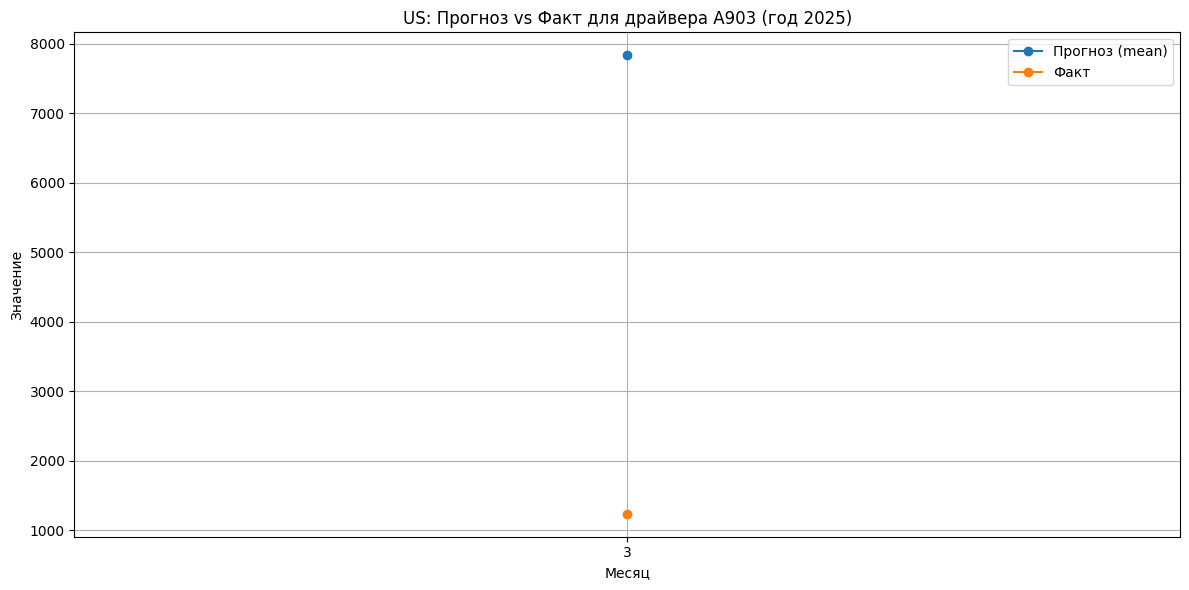

,year,month,gosb_code,driver_code,category,mean_forecast,fact,abs_error
2,2025,3,12,A903,Кат3,7834.2,1234.0,6600.2


In [207]:
# %% [markdown]
# ## 8. График: прогноз vs факт по одному (самому «плохому») драйверу

# %%
if not wape_us_result.empty and not df_us_merged.empty:
    # агрегируем по драйверу (сумма по всем ГОСБ и категориям)
    wape_us_by_driver = (
        wape_us_result
        .groupby("driver_code", as_index=False)
        .agg(
            abs_error_sum=("abs_error_sum", "sum"),
            fact_sum=("fact_sum", "sum")
        )
    )
    wape_us_by_driver["wape"] = wape_us_by_driver["abs_error_sum"] / wape_us_by_driver["fact_sum"]
    wape_us_by_driver = wape_us_by_driver.sort_values("wape", ascending=False)

    display(wape_us_by_driver.head())

    example_us_driver = wape_us_by_driver.iloc[0]["driver_code"]
    print("Драйвер для примера:", example_us_driver)

    df_us_example = df_us_merged[df_us_merged["driver_code"] == example_us_driver].copy()
    df_us_example = df_us_example.sort_values(["year", "month", "gosb_code"])

    if df_us_example.empty:
        print("Для выбранного драйвера нет строк в df_us_merged.")
    else:
        plt.figure()
        plt.plot(df_us_example["month"], df_us_example["mean_forecast"], marker="o", label="Прогноз (mean)")
        plt.plot(df_us_example["month"], df_us_example["fact"], marker="o", label="Факт")
        plt.xticks(sorted(df_us_example["month"].unique()))
        plt.xlabel("Месяц")
        plt.ylabel("Значение")
        plt.title(f"US: Прогноз vs Факт для драйвера {example_us_driver} (год {WAPE_YEAR_US})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        display(
            df_us_example[[
                "year", "month", "gosb_code", "driver_code", "category",
                "mean_forecast", "fact", "abs_error"
            ]].head(20)
        )
else:
    print("⚠️ Нет данных для построения графика (wape_us_result или df_us_merged пустые).")


График: прогноз vs факт по одному драйверу

Топ драйверов по WAPE:


,driver_code,abs_error_sum,fact_sum,wape
2,A903,6600.20,1234.0,5.348622
1,A902,4040.86,2935.0,1.376784
0,A901,8098.00,8898.8,0.910010


Драйвер для примера: A903


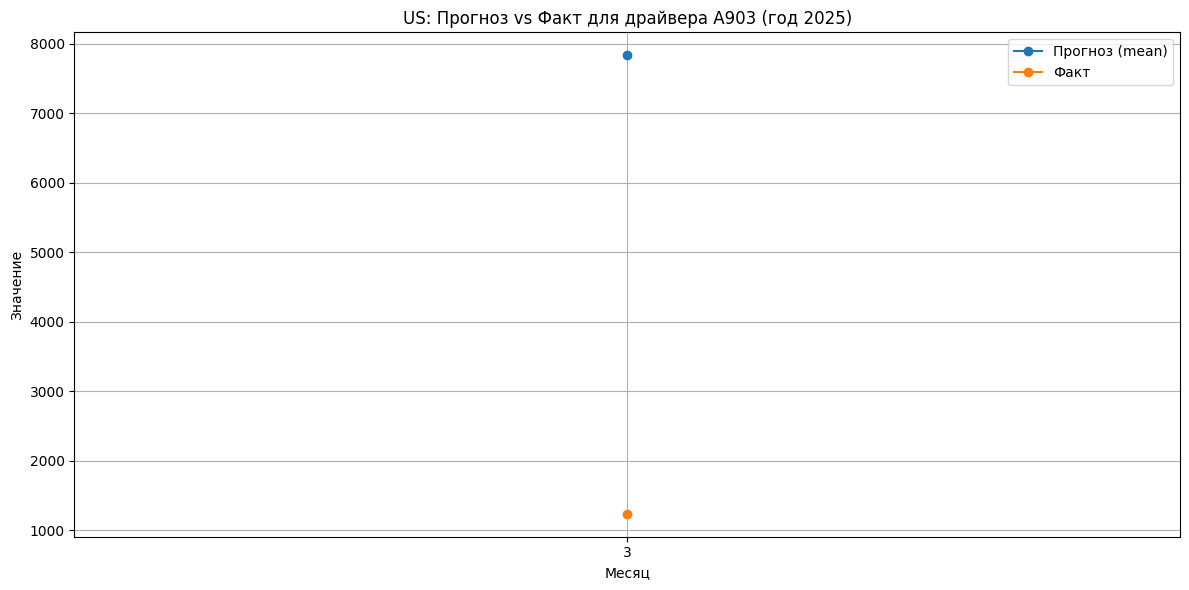

,year,month,gosb_code,driver_code,category,mean_forecast,fact,abs_error
2,2025,3,12,A903,Кат3,7834.2,1234.0,6600.2


In [208]:
# График: прогноз vs факт по одному драйверу (US)

if wape_us_result.empty or df_us_merged.empty:
    print("⚠️ Нет данных для построения графика (wape_us_result или df_us_merged пустые).")
else:
    # агрегируем WAPE по драйверу (суммарно по всем ГОСБ и категориям)
    wape_us_by_driver = (
        wape_us_result
        .groupby("driver_code", as_index=False)
        .agg(
            abs_error_sum=("abs_error_sum", "sum"),
            fact_sum=("fact_sum", "sum")
        )
    )
    wape_us_by_driver["wape"] = wape_us_by_driver["abs_error_sum"] / wape_us_by_driver["fact_sum"]
    wape_us_top = wape_us_by_driver.sort_values("wape", ascending=False)

    print("Топ драйверов по WAPE:")
    display(wape_us_top.head(10))

    if wape_us_top.empty:
        print("⚠️ wape_us_top пустой, нечего строить.")
    else:
        # Берём "самый плохой" драйвер из топа
        example_us_driver = wape_us_top.iloc[0]["driver_code"]
        print("Драйвер для примера:", example_us_driver)

        df_us_example = df_us_merged[df_us_merged["driver_code"] == example_us_driver].copy()
        df_us_example = df_us_example.sort_values(["year", "month", "gosb_code"])

        if df_us_example.empty:
            print("⚠️ Для выбранного драйвера нет строк в df_us_merged.")
        else:
            plt.figure()
            plt.plot(
                df_us_example["month"],
                df_us_example["mean_forecast"],
                marker="o",
                label="Прогноз (mean)"
            )
            plt.plot(
                df_us_example["month"],
                df_us_example["fact"],
                marker="o",
                label="Факт"
            )
            plt.xticks(sorted(df_us_example["month"].unique()))
            plt.xlabel("Месяц")
            plt.ylabel("Значение")
            plt.title(f"US: Прогноз vs Факт для драйвера {example_us_driver} (год {WAPE_YEAR_US})")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

            # Табличка по этому драйверу
            display(
                df_us_example[
                    ["year", "month", "gosb_code", "driver_code",
                     "category", "mean_forecast", "fact", "abs_error"]
                ].head(20)
            )


График: динамика по категориям (по месяцам)

,year,month,category,total_mean
0,2025,1,Кат1,678.50
1,2025,2,Кат2,6345.30
2,2025,3,Кат3,7834.20
3,2025,4,Кат1,122.30
4,2025,5,Кат2,389.44


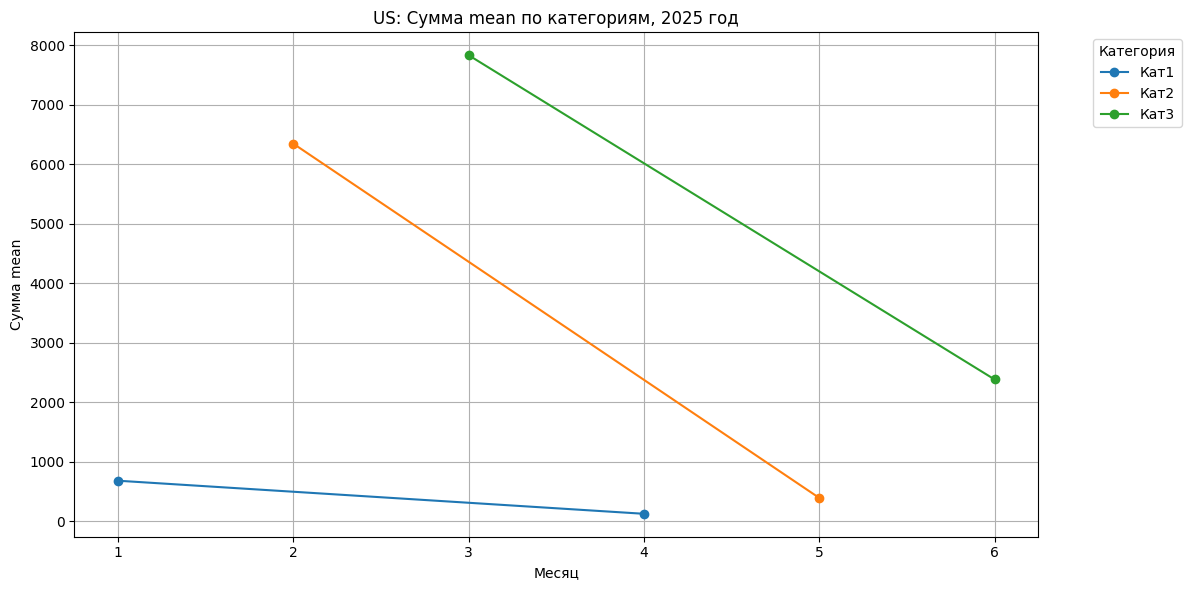

In [209]:
# Агрегация: сумма mean по годам/месяцам/категориям
us_agg_cat_month = (
    df_us_enriched
    .groupby(["year", "month", "category"], as_index=False)
    .agg(total_mean=("mean", "sum"))
)

display(us_agg_cat_month.head())



# График: динамика по категориям (по месяцам) для последнего года в данных

if us_agg_cat_month.empty:
    print("⚠️ us_agg_cat_month пустой, график построить нельзя.")
else:
    latest_year_us = us_agg_cat_month["year"].max()
    df_plot = us_agg_cat_month[us_agg_cat_month["year"] == latest_year_us].copy()

    if df_plot.empty:
        print(f"⚠️ Для года {latest_year_us} нет данных в us_agg_cat_month.")
    else:
        plt.figure()

        for cat, grp in df_plot.groupby("category"):
            plt.plot(
                grp["month"],
                grp["total_mean"],
                marker="o",
                label=str(cat)
            )

        plt.xlabel("Месяц")
        plt.ylabel("Сумма mean")
        plt.title(f"US: Сумма mean по категориям, {latest_year_us} год")
        plt.xticks(sorted(df_plot["month"].unique()))
        plt.legend(title="Категория", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()


График: барчарт по категориям за последний месяц

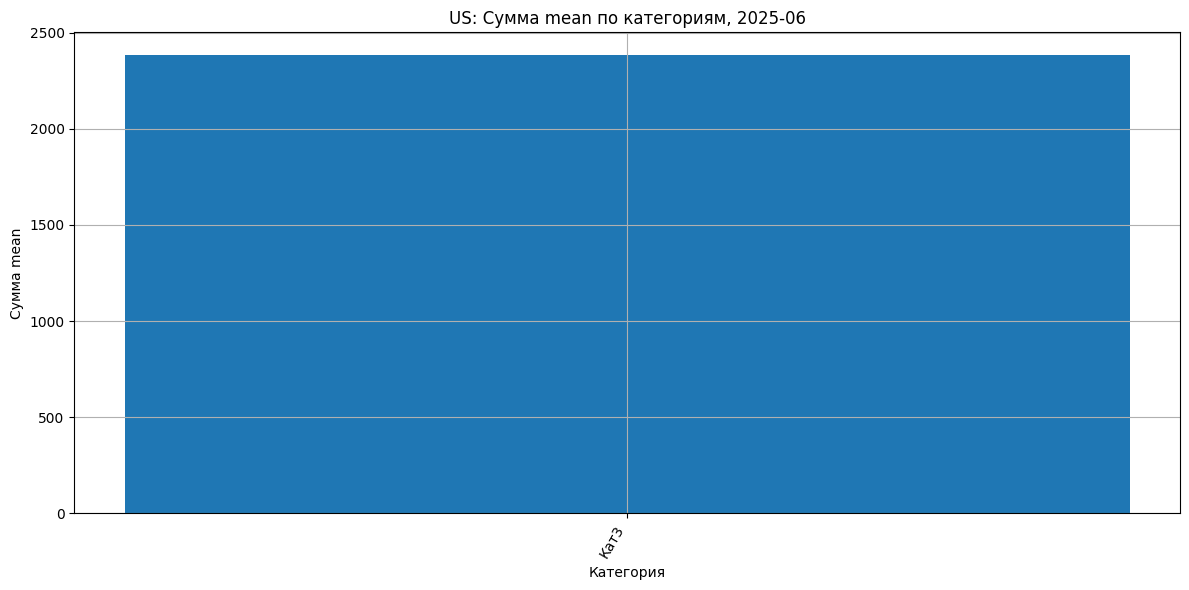

,category,total_mean
0,Кат3,2382.5


In [210]:
# Барчарт: сумма mean по категориям за последний месяц в данных

if df_us_enriched.empty:
    print("⚠️ df_us_enriched пустой, строить барчарт нельзя.")
else:
    latest_year_us = df_us_enriched["year"].max()
    latest_month_us = (
        df_us_enriched[df_us_enriched["year"] == latest_year_us]["month"].max()
    )

    df_last = (
        df_us_enriched[
            (df_us_enriched["year"] == latest_year_us) &
            (df_us_enriched["month"] == latest_month_us)
        ]
        .groupby("category", as_index=False)
        .agg(total_mean=("mean", "sum"))
        .sort_values("total_mean", ascending=False)
    )

    plt.figure()
    plt.bar(df_last["category"], df_last["total_mean"])
    plt.xticks(rotation=60, ha="right")
    plt.xlabel("Категория")
    plt.ylabel("Сумма mean")
    plt.title(f"US: Сумма mean по категориям, {latest_year_us}-{latest_month_us:02d}")
    plt.tight_layout()
    plt.show()

    display(df_last.head())


Фильтры по категории / подразделению

In [211]:
# Фильтры по категории / ГОСБ
US_FILTER_CATEGORIES = []       # пример: ["Revenue", "Cost"]
US_FILTER_GOSB_CODES = []       # пример: ["A901", "A902"]

def us_apply_filters(df):
    df_f = df.copy()
    
    if US_FILTER_CATEGORIES:
        df_f = df_f[df_f["category"].isin(US_FILTER_CATEGORIES)]
    if US_FILTER_GOSB_CODES:
        df_f = df_f[df_f["gosb_code"].isin(US_FILTER_GOSB_CODES)]
    
    return df_f

df_us_filtered = us_apply_filters(df_us_enriched)
display(df_us_filtered.head())


,item_id,timestamp,mean,driver_code,gosb_code,year,month,quarter_num,quarter,category
0,A901+12,2025-01-01,678.50,A901,12,2025,1,1,1Q,Кат1
1,A902+12,2025-02-02,6345.30,A902,12,2025,2,1,1Q,Кат2
2,A903+12,2025-03-03,7834.20,A903,12,2025,3,1,1Q,Кат3
3,A901+15,2025-04-04,122.30,A901,15,2025,4,2,2Q,Кат1
4,A902+15,2025-05-05,389.44,A902,15,2025,5,2,2Q,Кат2


Сводная таблица: категория × месяц

In [212]:
# Сводная таблица: категория × месяц по mean за последний год

if df_us_enriched.empty:
    print("⚠️ df_us_enriched пустой, сводную таблицу строить нельзя.")
else:
    latest_year_us = df_us_enriched["year"].max()

    df_pivot = df_us_enriched[df_us_enriched["year"] == latest_year_us].pivot_table(
        index="category",
        columns="month",
        values="mean",
        aggfunc="sum",
        fill_value=0
    )

    display(df_pivot)


month,1,2,3,4,5,6
category,,,,,,
Кат1,678.5,0.0,0.0,122.3,0.00,0.0
Кат2,0.0,6345.3,0.0,0.0,389.44,0.0
Кат3,0.0,0.0,7834.2,0.0,0.00,2382.5
